# Scatter Ptychography: a simulation demo
### Qian Huang
### 03/14/2022

This notebook implements forward simulation and the phase retrieval algorithm in the paper *Scatter Ptychography*.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.measure import block_reduce
from scipy import ndimage

import torch
import torch.nn as nn
import torch.nn.functional as F

import random

_seed = 19971017

random.seed(_seed)
np.random.seed(_seed % 2**32)
torch.manual_seed(_seed)

device='cuda' ## set to 'cpu' if cuda is unavailable

In [2]:
## helper functions

def print_stat(narray, narray_name = 'Array'):
    print(narray_name + f" shape: {narray.shape}, dtype: {narray.dtype}")
    arr = narray.flatten()
    print(narray_name + " stat: max: {}, min: {}, mean: {}, std: {}".format(arr.max(), arr.min(), arr.mean(), arr.std()))

def pad_to_size(img, size):
    h, w = img.shape
    left = (size - w)//2
    top = (size - h) //2
    return F.pad(img, (left, size-w-left, top, size-h-top))

def crop_to_size(img, size, offset=-1):
    h, w = img.shape
    left = (w - size)//2+offset 
    top = (h - size)//2+offset
    return img[top:top+size, left:left+size]

def show_stats(complex_img):
    plt.imshow(torch.abs(complex_img).to('cpu').numpy(), cmap='gray')
    plt.title('Amplitude')
    plt.show()
    print_stat(torch.abs(complex_img),'Amplitude')
    plt.imshow(torch.angle(complex_img).to('cpu').numpy(), cmap='gray')
    plt.title('Phase')
    plt.show()
    print_stat(torch.angle(complex_img),'Phase')
    
def save2png(path, img):
    if isinstance(img, torch.Tensor):
        if img.is_cuda:
            img = img.cpu()
        img = img.numpy()
    if img.dtype == np.complex128:
        img = np.abs(img)
    img = (img/img.max()*255.).astype(np.uint8)
    cv2.imwrite(path, img)

In [3]:
## propagation models

def CUASD(f, d, lam, p):
    # INPUT
    ## f: input field
    ## d: distance in m
    ## lam: wavelength in m
    ## p: pixel pitch size in m
    # OUTPUT
    ## g: output field
    pad = int((d*lam/p**2))//2*2+2 if d > 0 else 0
    inF = F.pad(f,(pad, pad, pad, pad))
    m, n = inF.size()
    urange = torch.linspace(-m/(2*p*m), (m-1)/(2*p*m), m).double()
    vrange = torch.linspace(-n/(2*p*n), (n-1)/(2*p*n), n).double()
    v, u = torch.meshgrid(vrange,urange)
    h = torch.exp(1j*2*np.pi*d*torch.sqrt((1/lam)**2 - u**2 - v**2)).to(device)
    g = torch.fft.ifft2(torch.fft.fftshift(h) * torch.fft.fft2(inF))
    return g

def cu_rescale(img, scale):
    return F.interpolate(img.unsqueeze(0).unsqueeze(0), scale_factor=scale,mode='bicubic').squeeze()

## MASM
def CUMASD(f, d, lam, p, x):
    # INPUT
    ## f: input field
    ## d: distance in m, positive
    ## lam: wavelength in m
    ## p: pixel pitch size in m
    ## x: object size in m
    # OUTPUT
    ## g: output field
    ## p_out: output field pixel pitch
    g = f
    p_out = p
    h_prev = 0
    while 2*(2*p_out)*x/lam*(p_out/p) < d:
        h = 2*(2*p_out)*x/lam*(p_out/p)
        g = CUASD(g, h-h_prev, lam, p_out)
        g = cu_rescale(torch.real(g),0.5)+1j*cu_rescale(torch.imag(g),0.5)
        h_prev = h
        p_out = 2*p_out
    g = CUASD(g, d-h_prev, lam, p_out)
    return g, p_out

## inverse MASM
def CURMASD(g, d, lam, p_out, p, x):
    # INPUT
    ## g: field to be back propagated
    ## d: reversal distance in m, positive
    ## lam: wavelength in m
    ## p_out: pixel pitch of g in m
    ## p: tolerable pixel pitch of f in m
    ## x: object size in m
    # OUTPUT
    ## f: reversed field
    ## p_in: pixel pitch of reversed field
    f = g
    p_in = p_out
    h_prev = d
    while p_in > p:
        h = 2*p_in*x/lam*(p_in/2/p)
        f = CUASD(f, h-h_prev, lam, p_in)
        pad = int((-(h-h_prev)*lam/p_in**2)//2*2+2)
        f = f[pad:-pad, pad:-pad]# remove padding
        f = cu_rescale(torch.real(f),2)+1j*cu_rescale(np.imag(f),2)
        h_prev = h
        p_in = p_in/2
    f = CUASD(f, -h_prev, lam, p_in)
    return f, p_in

## Forward Model

#### propagation

In [4]:
def forward_proc(offset, inspect=False, base=104.):
    theta = 1e-10

    unit = 10e-6#40e-6
    lam = 0.532e-6
    assert 2*unit < np.abs(lam/np.sin(theta))
    N = 1000
    urange=torch.arange(-N//2, N//2).double()
    vrange=torch.arange(-N//2, N//2).double()
    UU, VV = torch.meshgrid(vrange,urange)
    lf = torch.exp(1j*2*np.pi/lam*(UU*unit*np.sin(1e-10))).to(device)

    obj = cv2.imread('USAF_Resolution_Chart_A1-780.jpg', 0)
    obj = cv2.resize(obj, (0,0), fx=0.58, fy=0.52)/255.0
    obj = torch.from_numpy(obj.astype(np.complex128)).to(device)
    obj = pad_to_size(obj,N)*(1-1e-10)+1e-10
    of = lf*obj

    z = (base*25.4+offset)*1e-3
    x = 4e-3
    sf, p_out = CUMASD(of, z, lam, unit, x)

    return sf

#### camera model

In [5]:
class Camera:
    def __init__(self, fl, p, m, n, n_photons=None, n_shots=1):
        self.fl = fl
        self.p = p
        self.m = m
        self.n = n
        self.sensor_img = None
        self.n_photons = n_photons
        self.n_shots = n_shots

    ### project from the screen to the sensor
    def wall2sensor(self,img, R, t, pitch):
        ## R, t: world coor plane (Z=0) to cam coor
        ratio = 1
        while self.p/ratio*np.linalg.norm(t)/self.fl > 2*pitch:
            ratio += 1
        X_coor, Y_coor = np.meshgrid(np.arange(-(self.n*ratio)//2,(self.n*ratio)//2),np.arange(-(self.m*ratio)//2,(self.m*ratio)//2))
        X_cam, Y_cam = X_coor*self.p/ratio, Y_coor*self.p/ratio

        Z = -t[2]/(R[2, 2]+X_cam*R[0, 2]/self.fl) ## (x,y,z) in cam coor on the screen satisfies R^T.dot([x, y, z])_3 + t_3 = 0 (plane z=0) => ...

        p_cam = np.stack([X_cam*Z/self.fl, Y_cam*Z/self.fl, Z]).reshape((3,-1))
        p = R.T.dot(p_cam)+t
        Xs_coor, Ys_coor = p[0]/pitch, p[1]/pitch
        Xs_coor, Ys_coor = Xs_coor.reshape(X_coor.shape), Ys_coor.reshape(Y_coor.shape)
        size = int(max(Xs_coor.max()-Xs_coor.min(), Ys_coor.max()-Ys_coor.min()))
        self.sensor_img = Camera.bilinear_interp(np.pad(img,((size,size),(size,size))), Ys_coor, Xs_coor)
        if self.n_photons is not None:
            self.sensor_img = np.clip(self.sensor_img, 0, 1e10)
            self.sensor_img = self.sensor_img*self.n_photons
            temp = 0.
            for i in range(self.n_shots):
                temp += np.random.poisson(self.sensor_img)
            self.sensor_img = temp/(self.n_shots*self.n_photons)
        if ratio > 1:
            self.sensor_img = Camera.binning(self.sensor_img, ratio)
            print(ratio)

    def read_out_img(self):
        return self.sensor_img

    @staticmethod
    def bilinear_interp(img, Y_coor, X_coor):
        Y_coor_int, X_coor_int = np.floor(Y_coor).astype('int'), np.floor(X_coor).astype('int')
        delta_Y, delta_X = Y_coor-Y_coor_int, X_coor-X_coor_int
        m, n = img.shape
        Y_coor_int, X_coor_int = Y_coor_int+m//2, X_coor_int+n//2

        img_interp=(1-delta_Y)*(1-delta_X)*img[Y_coor_int,X_coor_int]+\
                        (delta_Y)*(1-delta_X)*img[Y_coor_int+1,X_coor_int]+\
                        (1-delta_Y)*(delta_X)*img[Y_coor_int,X_coor_int+1]+\
                        (delta_Y)*(delta_X)*img[Y_coor_int+1,X_coor_int+1]
        return img_interp

    @staticmethod
    def binning(img, ratio):
        return block_reduce(img, block_size=(ratio,ratio), func=np.mean)

In [6]:
### camera extrinsic parameters

theta = np.arcsin(1/5.478)
R = np.array([[np.cos(theta), 0, -np.sin(theta)],
     [0, 1, 0],
     [np.sin(theta), 0, np.cos(theta)]])
t = np.array([[-1*25.4, 0, -1*25.4/np.tan(theta)]]).T #mm
cam = Camera(12, 6.9e-3, 540, 720, n_photons=46810, n_shots=500) ## camera model: add poisson noise, 500 average

## Phase Retrieval

#### generate data

/home/u18/qh38/.local/lib/python3.6/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/home/u18/qh38/.local/lib/python3.6/site-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


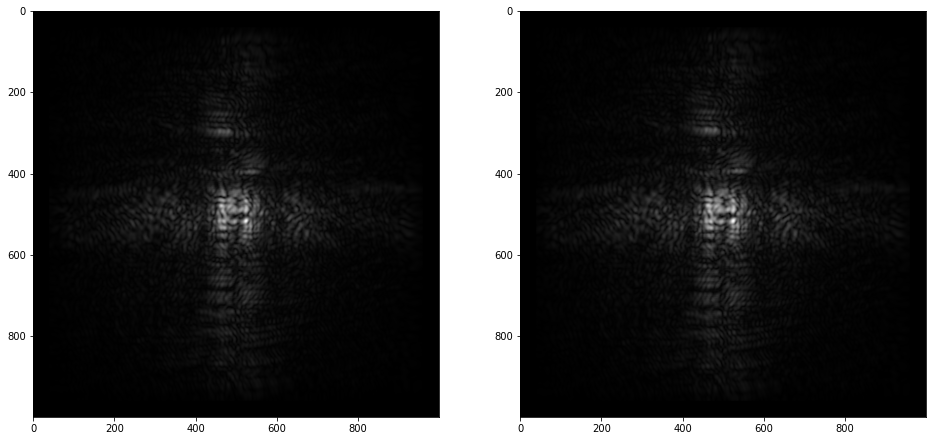

In [7]:
measurements=[]
z = []
k = 1
num_planes= 2
fig = plt.figure(figsize=(16, 8))
for offset in np.linspace(0, 50, num_planes):
    offset = int(offset)
    base = 104.5 
    z.append((base*25.4+offset)*1e-3) ## propagation distance
    img = forward_proc(offset, base=base)
    m, n = img.shape
    
    img_amp = cu_rescale(torch.abs(img)**2, 0.5) ## field to intensity
    cam.wall2sensor(img_amp.to('cpu').numpy(), R, t, 80e-3) ## screen to sensor projection
    img = np.sqrt(cam.read_out_img())  ## intensity to amplitude
    img = img[40:-40,130:-130]
    
    img = cu_rescale(torch.from_numpy(img).to(device), 2) ## projection
    img = pad_to_size(img, m) ## add enough padding
    measurements.append(img)
    plt.subplot(1,num_planes,k)
    plt.imshow(crop_to_size(torch.abs(img).to('cpu').numpy(),1000,0),cmap='gray')
    k+=1
plt.show()

#### initialization

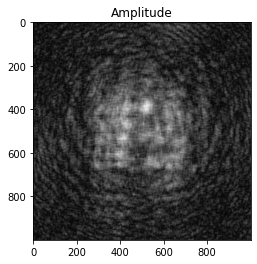

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 0.37723828719722763, min: 5.623751725429758e-05, mean: 0.07325337630910077, std: 0.049265987634539626


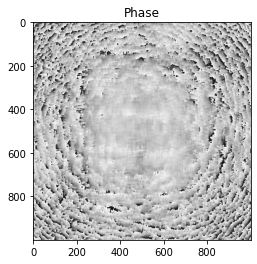

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.141578702648373, min: -3.1415897522784992, mean: 1.3886118254380053, std: 1.2369270677877058


In [8]:
unit = 10e-6
lam = 0.532e-6

index_c = 0
field_at_target_inv, p_in = CURMASD(torch.abs(measurements[index_c])*torch.exp(1j*(torch.randn_like(torch.abs(measurements[index_c])))), z[index_c], lam, 40e-6, unit, 4e-3)#ASD(measurements[index_c], -z[index_c], lam, unit)
show_stats(crop_to_size(field_at_target_inv, 1000, 0))

In [9]:
#### light: constant amplitude and phase

def calc_lf(N):
    theta = 1e-10
    urange=torch.arange(-N//2, N//2).double()
    vrange=torch.arange(-N//2, N//2).double()
    UU, VV = torch.meshgrid(vrange,urange)
    lf = torch.exp(1j*2*np.pi/lam*(UU*unit*np.sin(theta))).to(device)
    return lf

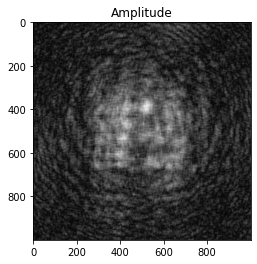

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 0.37723828719722763, min: 5.6237517254297585e-05, mean: 0.07325337630910077, std: 0.049265987634539626


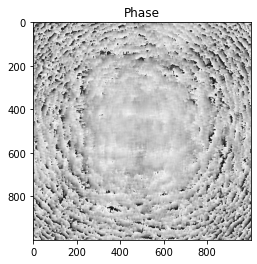

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415844543612383, min: -3.141584248586106, mean: 1.3886118313432545, std: 1.2369270967661075


In [10]:
target_est = field_at_target_inv/calc_lf(field_at_target_inv.shape[0])  ## initial estimation
target_est = crop_to_size(target_est, 1000, 0)
show_stats(target_est)

#### iterations

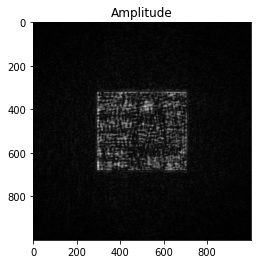

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 1.6744802890139918, min: 1.8126348787957526e-05, mean: 0.08256686627158549, std: 0.13757443324829877


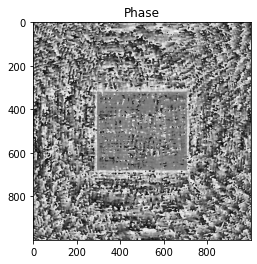

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.141586794905427, min: -3.1415863114455864, mean: 0.06468717976673798, std: 1.711269079571535


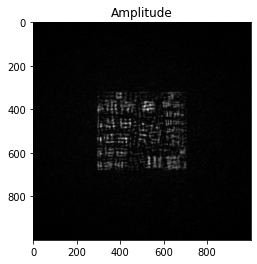

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 2.512200706107317, min: 2.1523476797912103e-05, mean: 0.06417188270829526, std: 0.14962072258607054


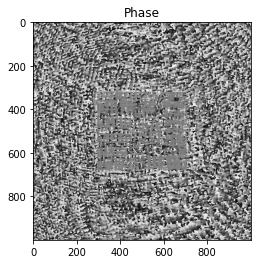

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415875254324166, min: -3.141588645364802, mean: 0.007861005503161026, std: 1.727269205477436


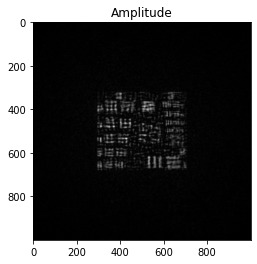

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 2.6186379234713235, min: 4.257834422832493e-05, mean: 0.06129023775097812, std: 0.150872454182642


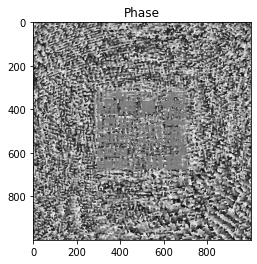

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415924328934515, min: -3.1415875035357868, mean: -0.005547568413618963, std: 1.717443516817516


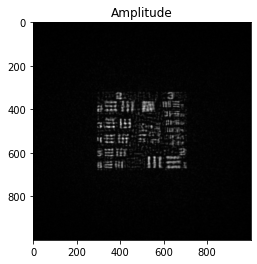

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 2.118553614537973, min: 2.0116168031137376e-05, mean: 0.05747793804001836, std: 0.15245266982243835


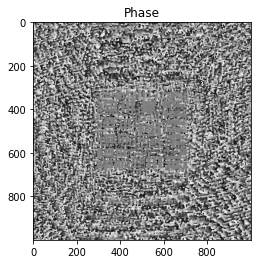

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.141589252102204, min: -3.141590392811939, mean: 0.0024257194252211537, std: 1.7175054625279136


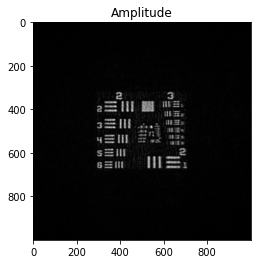

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 1.7458903180062, min: 6.841084259309672e-06, mean: 0.04897558039667859, std: 0.15566042352599302


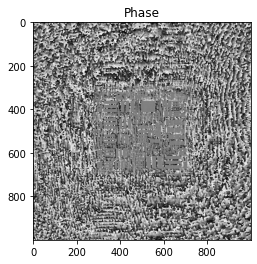

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415725815726314, min: -3.1415805886482047, mean: -0.005185220873957281, std: 1.705603006208925


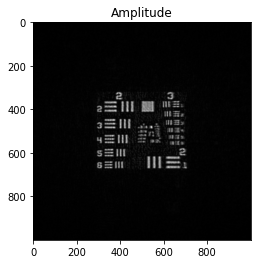

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 1.7683433115318352, min: 1.3939132789239512e-05, mean: 0.0486263615027581, std: 0.1557602082374592


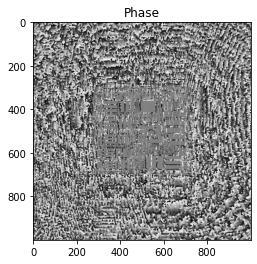

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.141591360923045, min: -3.1415681340568975, mean: 0.004689322378866964, std: 1.7049149287503138


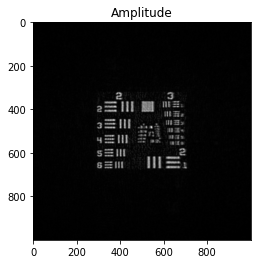

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 1.7819759453777526, min: 2.473360298605595e-06, mean: 0.04848340133183411, std: 0.15580742412545184


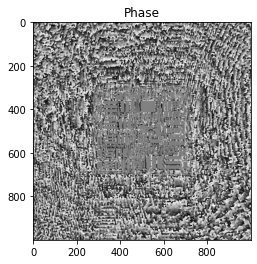

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415849847780364, min: -3.141587176478671, mean: 0.0019921996267094656, std: 1.7043516077167753


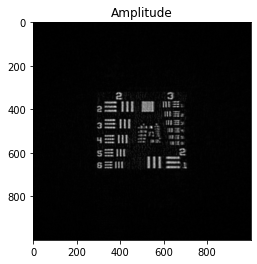

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 1.7617342260717015, min: 9.644334177660858e-06, mean: 0.048262356537177635, std: 0.1559007125599915


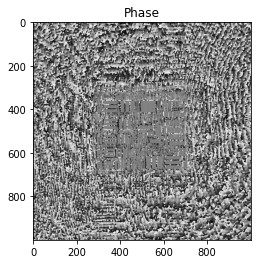

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415917517357808, min: -3.1415806763670213, mean: -0.006382292158764454, std: 1.7104509941166015


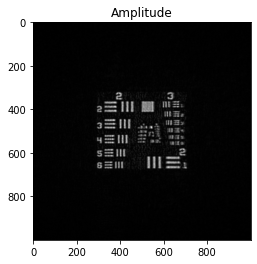

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 1.7372870259419007, min: 1.124075137273353e-05, mean: 0.04819277850944413, std: 0.1559201018895862


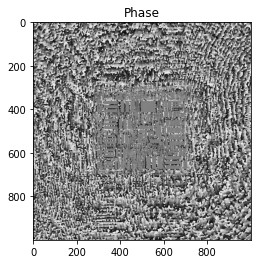

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415913119795067, min: -3.1415789361182185, mean: -0.009196182486430912, std: 1.7097234488785151


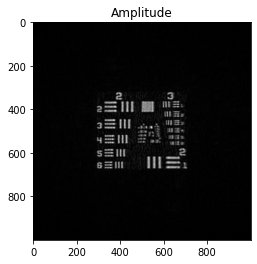

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 1.7427453784015052, min: 5.0724305427899505e-06, mean: 0.048400676248461394, std: 0.15582831639490216


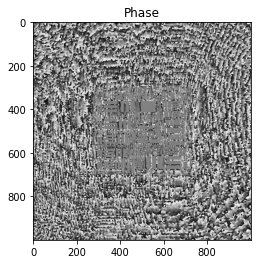

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415888515399892, min: -3.141592129408859, mean: -0.0008741778312577935, std: 1.704246091846058


In [11]:
# %%time
measurements_est = [i.cdouble() for i in measurements]
n = 200
for iter in range(n):
    idx_list = list(range(num_planes))
    random.shuffle(idx_list)
    for i in idx_list:
        h_pad, w_pad = 320, 294
        target_est = torch.abs(target_est)
        target_est[:h_pad] = 1e-10
        target_est[-h_pad:] = 1e-10
        target_est[:,:w_pad] = 1e-10
        target_est[:,-w_pad:] = 1e-10
        field_at_target = calc_lf(1000)*target_est.cdouble()
        sc, p_out = CUMASD(field_at_target, z[i], lam, unit, 4e-3)
        measurements_est[i] = torch.abs(measurements[i]).cdouble()*torch.exp(1j*torch.angle(sc))
        field_at_target_inv, p_in = CURMASD(measurements_est[i], z[i], lam, p_out, unit, 4e-3)
        target_est = crop_to_size(field_at_target_inv/calc_lf(field_at_target_inv.shape[0]), 1000, 0)
    if iter % 20 == 0:
        show_stats(crop_to_size(target_est, 1000, 0))

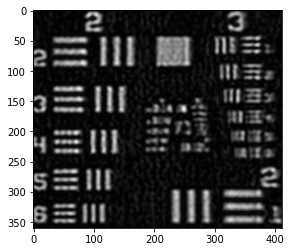

In [12]:
plt.imshow(torch.abs(target_est).to('cpu').numpy()[h_pad:-h_pad, w_pad:-w_pad], cmap='gray')
plt.show()